# Извлечение и визуализация MFCC

In [241]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pysptk
from scipy.io import wavfile as wav
import librosa


import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [242]:
from IPython.display import Audio

In [243]:
WAV_DIR = "C:/Users/yaha-/Desktop/VC/samples"
original = "bdl"
spoof = "rms"
filename_original = WAV_DIR+'/'+ original+'.wav'
filename_spoof = WAV_DIR+'/'+ spoof+'.wav'

In [244]:
sr, x = wav.read(filename_original)
sr2, x2 = wav.read(filename_spoof)

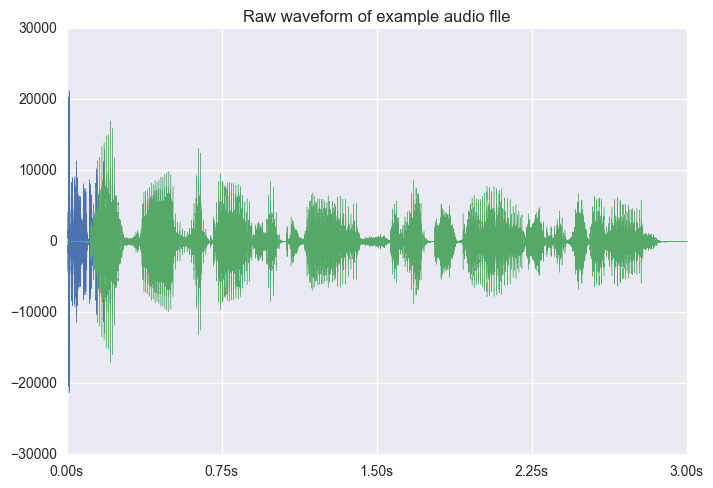

In [245]:
librosa.display.waveplot(x, sr=sr)
librosa.display.waveplot(x2, sr=sr2)
plt.title("Raw waveform of example audio flle")
Audio(x, rate=sr)

In [246]:
# Бьем на фреймы и применяем оконную функцию

frame_length = 1024
hop_length = 80

frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
frames2 = librosa.util.frame(x2, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T

#  Применяем оконную функцию

frames *= pysptk.blackman(frame_length)
frames2 *= pysptk.blackman(frame_length)

assert frames.shape[1] == frame_length 
assert frames2.shape[1] == frame_length 

# F0 оценка

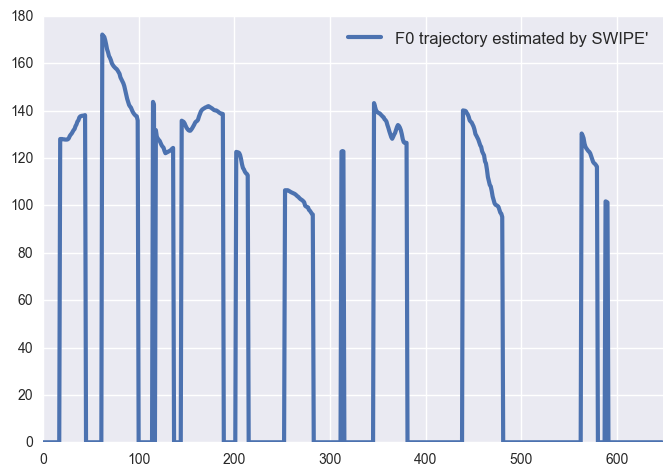

In [130]:
f0 = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="f0")
plt.plot(f0, linewidth=3, label="F0 trajectory estimated by SWIPE'")
plt.xlim(0, len(f0))
plt.legend(prop={'size': 12})
plt.show()

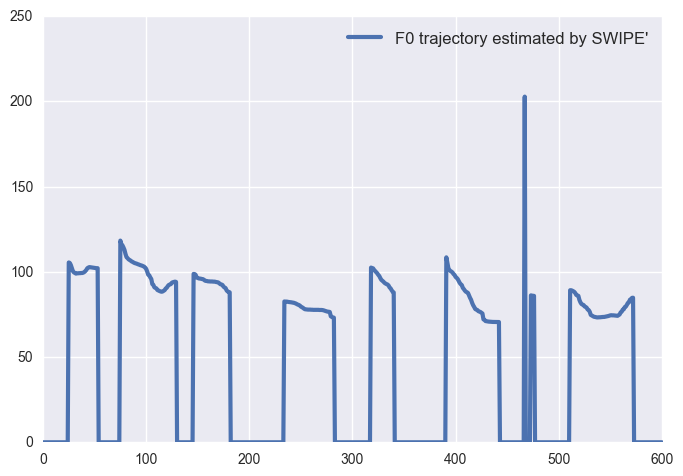

In [131]:
f0 = pysptk.swipe(x2.astype(np.float64), fs=sr2, hopsize=hop_length, min=60, max=240, otype="f0")
plt.plot(f0, linewidth=3, label="F0 trajectory estimated by SWIPE'")
plt.xlim(0, len(f0))
plt.legend(prop={'size': 12})
plt.show()

# Получаем MFCC

In [132]:
order = 25
alpha = 0.41

# применяяем функцию mcep вдоль оси "время" (=  1)
mcep = np.apply_along_axis(pysptk.mcep, 1, frames, order, alpha)

mcep2 = np.apply_along_axis(pysptk.mcep, 1, frames2, order, alpha)

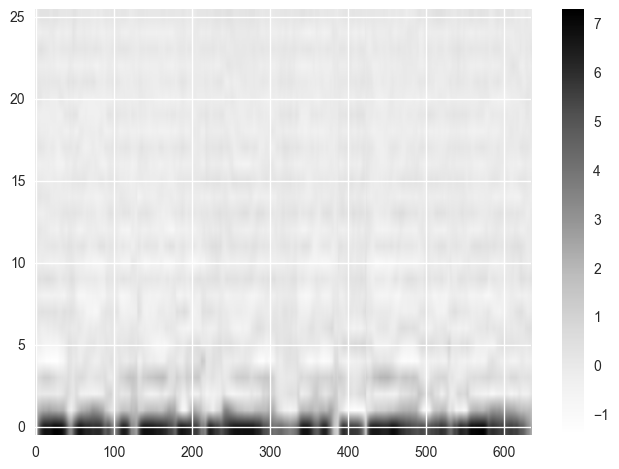

In [247]:
# Визуализация MFCC
plt.imshow(mcep.T, origin="lower", aspect="auto")
plt.colorbar()
plt.show()

# DTW

На данный момент DTW только в компоненте нулевого порядка mcep[:, 0]

In [248]:
# Выедем графиком исходные данные
mcep1 = mcep
mcep2 = mcep2
print mcep1.shape
print mcep2.shape

(635L, 26L)
(589L, 26L)


In [145]:
from dtw import dtw

dist, cost, acc, path = dtw(mcep1, mcep2, dist=lambda x, y: norm(x - y, ord=1))

In [148]:
aligned_mcep1 = mcep1[path[0]]
aligned_mcep2 = mcep2[path[1]]

print aligned_mcep1.shape, aligned_mcep2.shape

(663L, 26L) (663L, 26L)


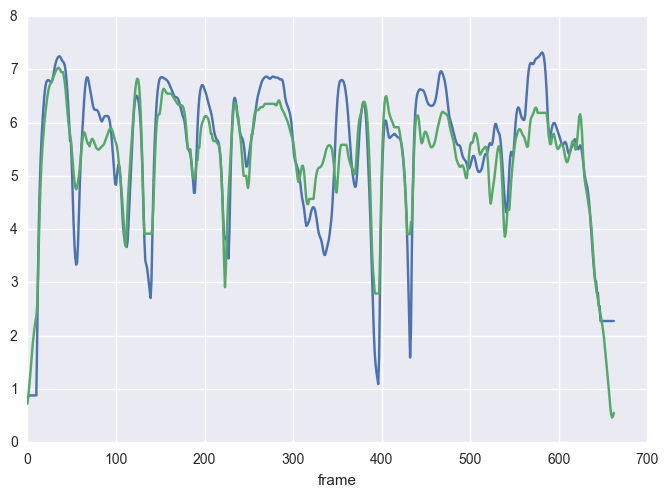

In [149]:
x = aligned_mcep1[:, 0]
y = aligned_mcep2[:, 0]

plt.plot(x)
plt.plot(y)
plt.xlabel("frame")

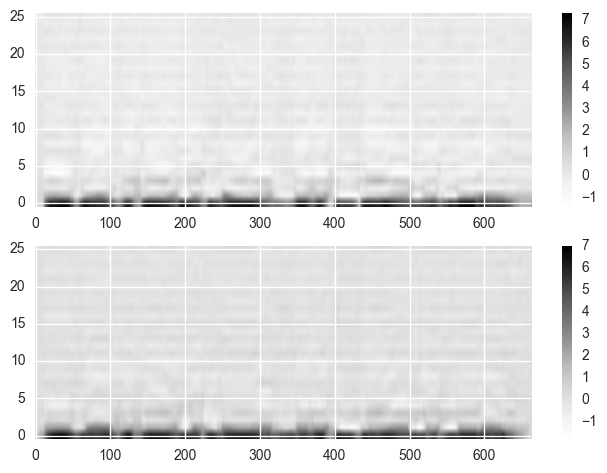

In [150]:
# Визуелизация исходных данных
plt.subplot("211")
plt.imshow(aligned_mcep1.T, origin="lower", aspect="auto")
plt.colorbar()
plt.subplot("212")
plt.imshow(aligned_mcep2.T, origin="lower", aspect="auto")
plt.colorbar()
plt.show()

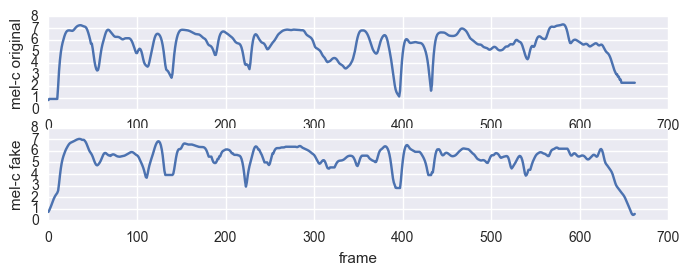

In [151]:

plt.figure()
plt.subplot("411")
plt.plot(aligned_mcep1[:, 0])
plt.xlabel("frame")
plt.ylabel("mel-c original")

plt.subplot("412")
plt.plot(aligned_mcep2[:, 0])
plt.xlabel("frame")
plt.ylabel("mel-c fake")



# Анализ и синтез

# GMM

In [138]:
import os
import numpy as np
from sklearn import mixture
from sklearn.utils import shuffle
from sklearn.externals import joblib
import matplotlib.pyplot as plt

In [153]:
# Создаем совместный вектор

print mcep.shape, mcep2.shape

X =  aligned_mcep1
Y = aligned_mcep2
print X.shape, Y.shape
Z = (np.hstack((X, Y)))
print Z.shape


(635L, 26L) (589L, 26L)
(663L, 26L) (663L, 26L)
(663L, 52L)


In [154]:
g = mixture.GMM(n_components=50, covariance_type='full')
%time g.fit(Z)
print g


(663L, 52L)
Wall time: 2.85 s
GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=50, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [155]:
print g.means_.shape
print g.covars_.shape

(50L, 52L)
(50L, 52L, 52L)


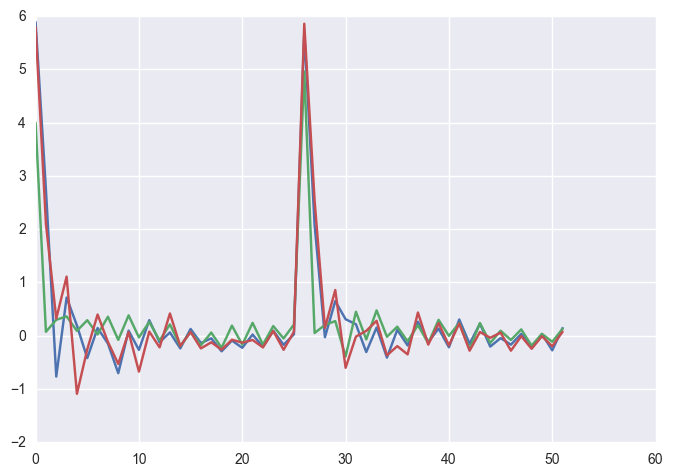

In [156]:
for k in range(3):
    plt.plot(g.means_[k, :])
plt.show()

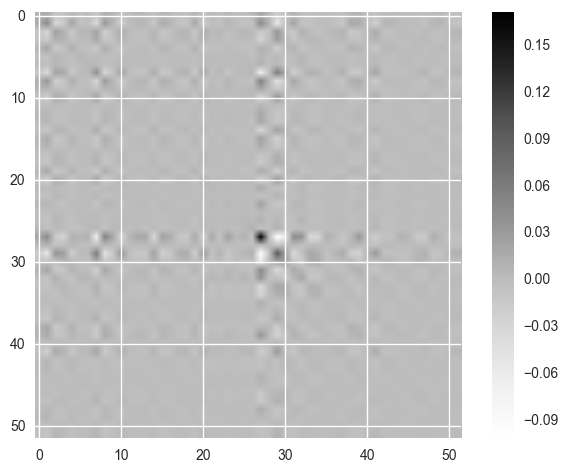

In [157]:
plt.imshow(g.covars_[0])
plt.colorbar()
plt.show()

# Голосовое преобразование

[ 0.78195545  0.73150287  0.47189795  0.58155362  0.2740359   0.26119642
  0.13829031  0.25783496  0.03877782  0.20032111  0.09942517  0.26696042
  0.08257769  0.16148457  0.08809451 -0.01716114  0.03345885  0.07507304
 -0.09664537 -0.01182746  0.07225878  0.06010629 -0.06425649  0.02541195
  0.04510753 -0.02951509]
[ 0.95929481  0.50768648  0.13449808  0.33307203  0.1313967   0.14298225
  0.01223157  0.2037608   0.04089562  0.06840932  0.03176533  0.11502572
  0.11221761  0.16212496  0.0752265   0.17405458  0.04390716  0.12441222
  0.10316553  0.06602216  0.01401131  0.15407152  0.03133743  0.09899537
  0.14371753  0.12218939]
[ 0.72527029  0.48025839  0.13924973  0.31889719  0.15471443  0.10864556
  0.040417    0.19533928  0.05597237  0.05578308  0.07286984  0.091262
  0.13933789  0.14444853  0.10141575  0.18016369  0.06228969  0.09789924
  0.1332036   0.0430577   0.01077459  0.13732898  0.03759635  0.08765336
  0.15698741  0.12889443]


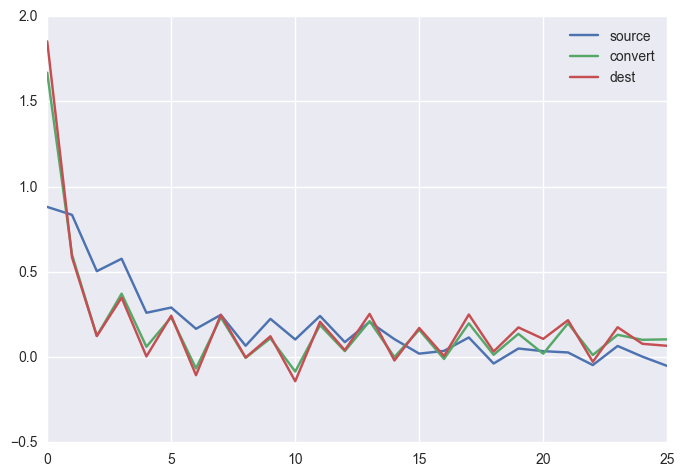

In [158]:
from scipy.stats import multivariate_normal
# преобразование голосовых характеристик по статье
# http://isw3.naist.jp/~tomoki/Tomoki/Journals/IEEE-Nov-2007_MLVC.pdf

M = 50
d = 26

# формула 9
def P(m, x, g):
    M = g.weights_.shape[0]
    if m >= M:
        print "ERROR: out of range: %d >= %d" % (m, M)
        exit()
    
    # Вычисление знаменателя
    denom = 0
    for n in range(M):
        denom += g.weights_[n] * multivariate_normal.pdf(x, g.means_[n, 0:d], g.covars_[n, 0:d, 0:d])
    
    nume = g.weights_[m] * multivariate_normal.pdf(x, g.means_[m, 0:d], g.covars_[m, 0:d, 0:d])

    return nume / denom

# Формула 11
def E(m, x):
    first = g.means_[m, d:]
    second = np.dot(g.covars_[m, d:, 0:d], np.linalg.inv(g.covars_[m, 0:d, 0:d]))
    return first + np.dot(second, x - g.means_[m, 0:d])

# Формула 13
def convert(x):
    res = 0.0
    for m in range(M):
        res += P(m, x, g) * E(m, x)
    return res

print X[0]
print convert(X[0].T)
print Y[0]

target = 6
plt.plot(X[target], label="source")
plt.plot(convert(X[target]), label="convert")
plt.plot(Y[target], label="dest")
plt.legend()

In [162]:
mfcc_conv =  convert(X[target])
print mfcc_conv.shape

(26L,)


In [215]:
converted_speech = []
n=0
for x in mcep1:
    print n
    y = convert(x)
    converted_speech.append([y])
    n=n+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [229]:
ch = np.array(converted_speech).reshape(-1,26)

In [191]:
pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="pitch")
source_excitation = pysptk.excite(pitch, hop_length)

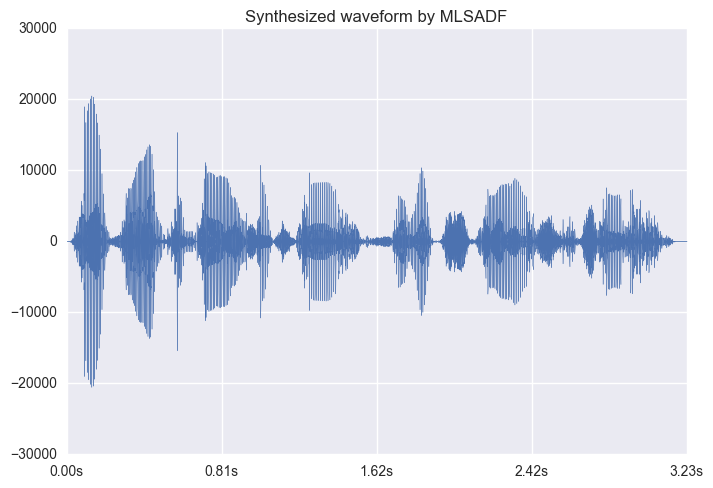

In [252]:
from pysptk.synthesis import MLSADF, Synthesizer

# Convert mel-cesptrum to MLSADF coefficients
b = np.apply_along_axis(pysptk.mc2b, 1,ch, alpha);

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(x_synthesized, sr=sr)
plt.title("Synthesized waveform by MLSADF")
Audio(x_synthesized, rate=sr)

In [262]:
a, b = librosa.load(filename_original)
print a

[  8.79394865e-05   5.89044321e-05   3.37173083e-06 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


In [281]:
print x_synthesized.astype('int')
np.savetxt('ch.txt', ch)
librosa.output.write_wav('file_trim_5s.wav', x_synthesized, sr)

[-2  1 -1 ...,  0  0  0]
[3 1 0 ..., 0 0 0]
